# CIFAR-10

**Task description:** Take the CIFAR-10 dataset. Train a network, which is able to predict for a given input image whether an animal or a vessel is included, and whether the depicted object can fly, walk, jump or swim.

**Groud truth:**


| label |  name  | animal or vessel  | fly, walk, jump, or swim  |
|---|---|---|---|
| 0  |airplane | none | fly |
| 1  |automobile | none | none |
| 2  |bird | animal | fly, walk, jump |
| 3  |cat | animal | walk, jump, swim |
| 4  |deer | animal | walk, jump, swim |
| 5  |dog | animal | walk, jump, swim |
| 6  |frog | animal | jump, swim |
| 7  |horse | animal | walk, jump, swim |
| 8  |ship | vessel | swim |
| 9  |truck | none | none |

In [48]:
label_map = {
    0: {
        "label_name": "airplane",
        "animal_or_vessel": "none",
        "movement": ["fly"],
    },
    1: {
        "label_name": "automobile",
        "animal_or_vessel": "none",
        "movement": ["none"],
    },
    2: {
        "label_name": "bird",
        "animal_or_vessel": "animal",
        "movement": ["fly", "walk", "jump"],
    },
    3: {
        "label_name": "cat",
        "animal_or_vessel": "animal",
        "movement": ["walk", "jump", "swim"],
    },
    4: {
        "label_name": "deer",
        "animal_or_vessel": "animal",
        "movement": ["walk", "jump", "swim"],
    },
    5: {
        "label_name": "dog",
        "animal_or_vessel": "animal",
        "movement": ["walk", "jump", "swim"],
    },
    6: {
        "label_name": "frog",
        "animal_or_vessel": "animal",
        "movement": ["jump", "swim"],
    },
    7: {
        "label_name": "horse",
        "animal_or_vessel": "animal",
        "movement": ["walk", "jump", "swim"],
    },
    8: {
        "label_name": "ship",
        "animal_or_vessel": "vessel",
        "movement": ["swim"],
    },
    9: {
        "label_name": "truck",
        "animal_or_vessel": "none",
        "movement": ["none"]
    },
}
movement_map = {
    "fly": 0,
    "walk": 1,
    "jump": 2,
    "swim": 3,
    "none": 4
}
animal_vessel_map = {
    "animal": 0,
    "vessel": 1,
    "none": 2
}

In [49]:
def transform_target(y):
    animal_vessel_idx = animal_vessel_map[label_map[y]["animal_or_vessel"]]
    movement_idx = [movement_map[m] for m in label_map[y]["movement"]]
    return (
        torch.zeros(3, dtype=torch.float).scatter_(0, torch.tensor(animal_vessel_idx), value=1),
        torch.zeros(5, dtype=torch.float).scatter_(0, torch.tensor(movement_idx), value=1)
    )

In [50]:
import torch
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda

training_data = datasets.CIFAR10(
    root="/tmp",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=Lambda(lambda y: transform_target(y))
)
test_data = datasets.CIFAR10(
    root="/tmp",
    train=False,
    download=True,
    transform=ToTensor(),
    target_transform=Lambda(lambda y: transform_target(y))
)

Files already downloaded and verified
Files already downloaded and verified


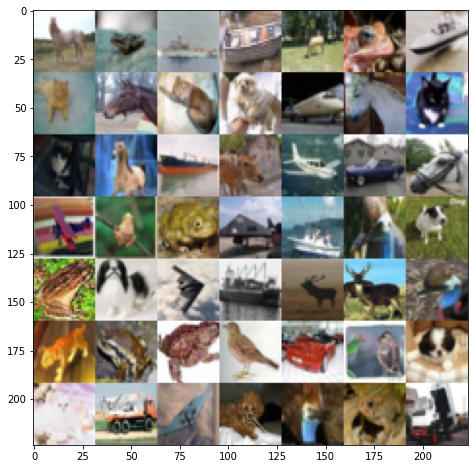

In [51]:
import matplotlib.pyplot as plt

n = 49
sample = torch.stack([training_data[i.item()][0] for i in torch.randint(0, len(training_data), (n, ))])
plt.figure(figsize=(8,8))
plt.imshow(torch.hstack(torch.unbind(sample.movedim(1, 3).reshape(int(n**(1/2)), -1, 32, 3))))

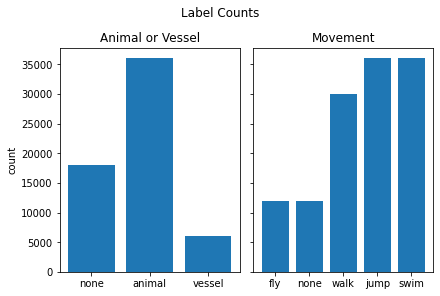

In [92]:
# label distribution can be computed based on the frequencies of the original labels
# https://www.cs.toronto.edu/~kriz/cifar.html
import collections

images_per_class = 5000 + 1000
animal_vessel_freq = collections.defaultdict(int)
movement_freq = collections.defaultdict(int)
for label in label_map.values():
    animal_vessel_freq[label["animal_or_vessel"]] += images_per_class
    for m in label["movement"]:
        movement_freq[m] += images_per_class

fig, ax = plt.subplots(1, 2, sharey=True, constrained_layout=True)
ax[0].bar(range(len(animal_vessel_freq)), list(animal_vessel_freq.values()), tick_label=list(animal_vessel_freq.keys()))
ax[1].bar(range(len(movement_freq)), list(movement_freq.values()), tick_label=list(movement_freq.keys()))
ax[0].set_ylabel("count")
ax[0].set_title("Animal or Vessel")
ax[1].set_title("Movement")
fig.suptitle("Label Counts")
plt.show()